In [ ]:
Portfolio Simulation - Monte Carlo Analysis
This notebook performs Monte Carlo simulations to analyze the distribution of a diversified portfolio, based on parameters such as average returns and volatilities.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColorBar, ColumnDataSource
from bokeh.palettes import Viridis256
from bokeh.transform import linear_cmap


output_notebook()


Loading BokehJS ...

In [2]:
initial_capital = 100000  
num_simulations = 1000  
days = 252 

portfolio = {
    "QQQ": {"percentage": 20, "mean_return": 0.08, "volatility": 0.15},
    "SP600 (IJR)": {"percentage": 15, "mean_return": 0.07, "volatility": 0.14},
    "XLP": {"percentage": 10, "mean_return": 0.05, "volatility": 0.10},
    "VTI": {"percentage": 10, "mean_return": 0.06, "volatility": 0.12},
    "XLI": {"percentage": 5, "mean_return": 0.06, "volatility": 0.11},
    "XLRE": {"percentage": 5, "mean_return": 0.05, "volatility": 0.10},
    "MSFT": {"percentage": 10, "mean_return": 0.12, "volatility": 0.20},
    "NVDA": {"percentage": 8, "mean_return": 0.15, "volatility": 0.30},
    "AAPL": {"percentage": 8, "mean_return": 0.10, "volatility": 0.22},
    "TACK ETF": {"percentage": 6, "mean_return": 0.08, "volatility": 0.18},
    "AMZN": {"percentage": 5, "mean_return": 0.09, "volatility": 0.25},
    "TSLA": {"percentage": 3, "mean_return": 0.15, "volatility": 0.35},
}


In [3]:
def montecarlo_simulation(portfolio, initial_capital, num_simulations, days):
    results = np.zeros((num_simulations, days))
    for asset, data in portfolio.items():
        weight = data["percentage"] / 100
        daily_return = data["mean_return"] / 252
        daily_volatility = data["volatility"] / np.sqrt(252)
        
        for i in range(num_simulations):
            daily_changes = np.random.normal(daily_return, daily_volatility, days)
            trajectory = initial_capital * weight * np.exp(np.cumsum(daily_changes))
            results[i, :] += trajectory

    return results


In [7]:
simulated_results = montecarlo_simulation(portfolio, initial_capital, num_simulations, days)
final_values = simulated_results[:, -1]

mean_final = np.mean(final_values)
std_final = np.std(final_values)
percentile_5 = np.percentile(final_values, 5)
percentile_95 = np.percentile(final_values, 95)

print(f"Average portfolio value: ${mean_final:,.2f}")
print(f"Standar deviation: ${std_final:,.2f}")
print(f"Percentile 5% (VaR): ${percentile_5:,.2f}")
print(f"Percentile 95%: ${percentile_95:,.2f}")


Valor promedio del portafolio: $116,403.57
Desviación estándar: $6,692.46
Percentil 5% (VaR): $105,947.53
Percentil 95%: $127,494.70


In [9]:
hist, edges = np.histogram(final_values, bins=30)
p = figure(title="Simulated Portfolio Distribution", x_axis_label='Portfolio Value ($)', y_axis_label='Frequency')

color_mapper = linear_cmap(field_name='top', palette=Viridis256, low=min(hist), high=max(hist))
p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], fill_color=color_mapper)

color_bar = ColorBar(color_mapper=color_mapper["transform"], width=8, location=(0, 0))
p.add_layout(color_bar, 'right')

p.line(x=[mean_final, mean_final], y=[0, max(hist)], line_width=2, color="blue", legend_label="Average")
show(p)


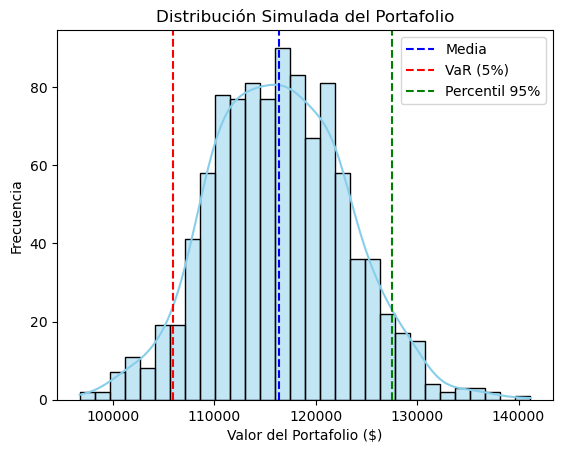

In [11]:
sns.histplot(final_values, bins=30, kde=True, color="skyblue", edgecolor="black")
plt.axvline(mean_final, color="blue", linestyle="--", label="Average")
plt.axvline(percentile_5, color="red", linestyle="--", label="VaR (5%)")
plt.axvline(percentile_95, color="green", linestyle="--", label="Percentile 95%")
plt.title("Simulated Portfolio Distribution")
plt.xlabel("Portfolio Value ($)")
plt.ylabel("Frequency")
plt.legend()
plt.show()


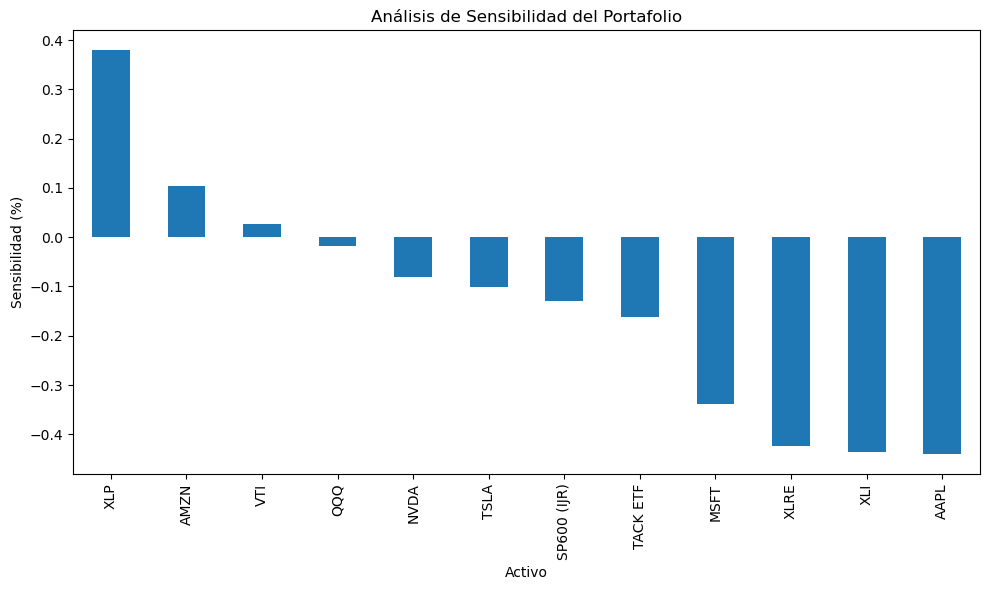

In [17]:
sensitivity_results = {}
for asset, data in portfolio.items():
    original_mean = np.mean(final_values)
    modified_portfolio = portfolio.copy()
    modified_portfolio[asset]["mean_return"] *= 1.01
    modified_results = montecarlo_simulation(modified_portfolio, initial_capital, num_simulations, days)
    modified_mean = np.mean(modified_results[:, -1])
    sensitivity_results[asset] = 100 * (modified_mean - original_mean) / original_mean

sensitivity_df = pd.DataFrame.from_dict(sensitivity_results, orient='index', columns=['Sensitivity (%)'])
sensitivity_df.sort_values(by="Sensitivity (%)", ascending=False).plot(kind="bar", figsize=(10, 6), legend=False)
plt.title("Sensitivity Portfolio Analysis")
plt.xlabel("Asset")
plt.ylabel("Sensitivity (%)")
plt.tight_layout()
plt.show()


In [15]:
results_df = pd.DataFrame(simulated_results)
results_df.to_csv("simulated_portfolio_results.csv", index=False)

statistics_df = pd.DataFrame({
    "Final Mean": [mean_final],
    "Standar Deviation": [std_final],
    "Percentile 5% (VaR)": [percentile_5],
    "Percentile 95%": [percentile_95]
})
statistics_df.to_csv("portfolio_statistics.csv", index=False)
